# Projet Histogram of oriented gradient

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import itertools
from scipy.ndimage.interpolation import shift
import math

## 1 :  Préparer les données

**Première étape** : On redimensionne les images en (64 x 128) pour nous faciliter les calculs par la suite. Le ratio doit être 1:2. 

Nous faisons cela car nous allons diviser les images en cellules de 8x8 et 16x16.

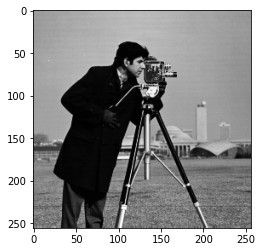

taille de l'image :  (256, 256)


In [2]:
path_base = '../Image/'
image_cam = cv2.imread(path_base+'cameraman.tif',0) 

plt.imshow(image_cam,'gray')
plt.show()
print("taille de l'image : ", image_cam.shape)

In [3]:
dsize= (64,128)
image_cam = cv2.resize(image_cam, dsize, interpolation = cv2.INTER_AREA)

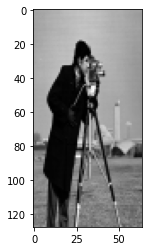

taille de l'image :  (128, 64)


In [4]:
plt.imshow(image_cam,'gray')
plt.show()
print("taille de l'image : ", image_cam.shape)

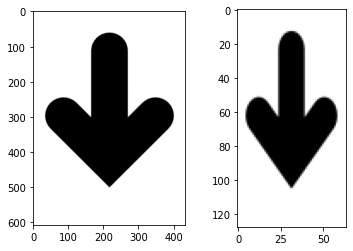

In [5]:
image_fleche = cv2.imread(path_base+'Fleche.jpg',0) 

plt.figure()

plt.subplot(1,2,1)
plt.imshow(image_fleche,'gray')

dsize= (64,128)
image_fleche = cv2.resize(image_fleche, dsize, interpolation = cv2.INTER_AREA)

plt.subplot(1,2,2)
plt.imshow(image_fleche,'gray')
plt.show()

## 2 : Calcule des gradients (directions x et y)

La prochaine étape est de calculer les gradients sur chaque pixel. 

Nous avons besoin des valeurs des pixels à gauche et à droite pour calculer le gradient dans le direction x. De même, nous avons besoin des valeurs au-dessus et en-dessous pour calculer le gradient dans la direction y. 

Dans les algorithmes de traitement d'image, la dérivée d'une image peut être approchée par le biais d’un filtrage différentiel.

In [6]:
masque = np.array([[-1,0,1]])

In [7]:
def matrice_x(img, h):
    h_rows,h_cols=h.shape
    rows,cols = img.shape
    
    # création de large_img plus grande pour appliquer le masque sur out_img
    large_img = np.zeros((rows+h_rows-1,cols+h_cols-1))
    large_img[h_rows//2:h_rows//2+rows,h_cols//2:h_cols//2+cols]=img
    out_img = np.zeros((rows,cols))
    
    for i in range(rows):
        for j in range(cols):
            out_img[i,j]=np.sum(large_img[i:i+h_rows,j:j+h_cols]*h)

    # Méthode simple pour régler les problèmes de bords
    out_img[:,0] = out_img[:,1]
    out_img[:,cols-1] = out_img[:,cols-2]
    out_img[0,:] = out_img[1,:]
    out_img[rows-1,:] = out_img[rows-2,:]
    
    return out_img

def matrice_y(img, h):
    return matrice_x(img, h.T)

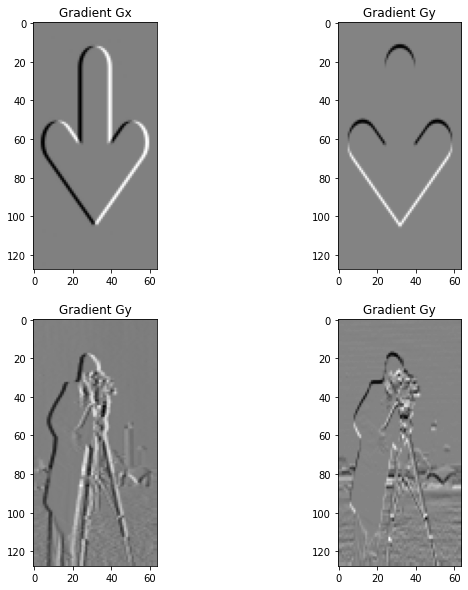

In [8]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(matrice_x(image_fleche, masque), 'gray')
plt.title("Gradient Gx")

plt.subplot(2,2,2)
plt.imshow(matrice_y(image_fleche, masque), 'gray')
plt.title("Gradient Gy")

plt.subplot(2,2,3)
plt.imshow(matrice_x(image_cam, masque), 'gray')
plt.title("Gradient Gy")

plt.subplot(2,2,4)
plt.imshow(matrice_y(image_cam, masque), 'gray')
plt.title("Gradient Gy")

plt.show()

## 3 : Calcule des orientations et des magnitudes

Formules pour les calculs : 

$$magnitude=\sqrt{G_x^2+G_y^2}$$

$$orientation = arctan(\frac{G_y}{G_x})$$

In [9]:
from numpy import arctan2

def magnitude_and_orientation(gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2)
    
    orientation = (arctan2(gy, gx) * 180 / np.pi)
    orientation = orientation%180
    
    return magnitude, orientation

m_cam, o_cam = magnitude_and_orientation(matrice_x(image_cam, masque),matrice_y(image_cam, masque))
m_fleche, o_fleche = magnitude_and_orientation(matrice_x(image_fleche, masque),matrice_y(image_fleche, masque))

## 4 : Calcule des histogrammes par cellules (8x8)

Fonction pour afficher un histogramme :

In [10]:
hist_bins = np.array([0,20,40,60,80,100,120,140,160])

In [11]:
def afficher_hist(hist, hist_bins):
    # nombre de barre sur l'histogramme
    pos = np.arange(len(hist_bins))
    
    width = 1
    ax = plt.axes()
    ax.set_xticks(pos - (width / 2))
    ax.set_xticklabels(hist_bins)

    plt.bar(pos, hist, width, color='grey', edgecolor="black")
    plt.title("Histogram of Gradients")
    plt.xlabel("Orientation")
    plt.ylabel("Gradient Magnitude")
    plt.show()

On va maintenant créer des cellules de 8x8 pixels on calculer pour chaque cellule l'histogramme des gradients orientés. De ce fait, nous obtenons les caractéristiques (ou histogramme).

Si nous divisons l'image en 8×8 cellules et générons les histogrammes, nous obtiendrons une matrice 9 x 1 pour chaque cellule. Au total nous aurons 8x16 cellules.

Voici une image pour comprendre la répartition dans chaque matrice : 

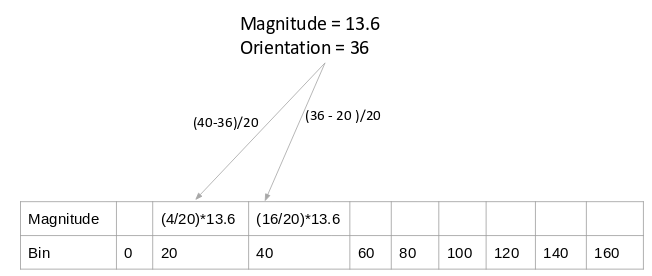

In [12]:
def histogram_per_cell(img, o, m):
    hist_bins = np.array([0,20,40,60,80,100,120,140,160])
    
    rows,cols = img.shape
    cells = (cols//8)*(rows//8)
    histograms = np.zeros(((rows//8),(cols//8),9))
    
    k = 0 # nombre de cellules parcourues. Le max est 128
    l = 0 # nombre de pixels parcourus sur chaque ligne. 8 dans une cellule et 64 sur une ligne de l'image.
    cell_x = 0 # numéro de la cellule sur x
    cell_y = 0 # numéro de la cellule sur y

    while True:
        for i in range(8):
            for j in range(8):
                # calcul du bin (entre 0 et 160) auquel le pixel doit être affecté
                case_inf = int(np.floor(o[i+k,j+l]/20))
                
                # Si le degré est entre 160 et 180, m est partagé avec la case 0 qui correspond à 0°-20°
                if (case_inf == 8):
                    m1 = ((180-o[i+k,j+l])/20) * m[i+k,j+l]
                    m2 = ((o[i+k,j+l]-hist_bins[case_inf])/20) * m[i+k,j+l]
                    
                    histograms[cell_y, cell_x, case_inf] += m1
                    histograms[cell_y, cell_x, 0] += m2 
                    
                # Sinon : on peut faire hist_bins[case_inf + 1] sans problème
                else:
                    m1 = ((hist_bins[case_inf+1]-o[i+k,j+l])/20) * m[i+k,j+l]
                    m2 = ((o[i+k,j+l]-hist_bins[case_inf])/20) * m[i+k,j+l]
                    
                    histograms[cell_y, cell_x, case_inf] += m1
                    histograms[cell_y, cell_x, case_inf + 1] += m2 
                
        cell_x += 1
        l += 8

        # Si on arrive à 8 fenêtres sur une même ligne :
        # On passe à la ligne d'après (k += 8)
        # Et on revient à la première colonne (l = 0)
        if (l == 64):
            cell_x = 0
            cell_y += 1
            l = 0
            k += 8

        # Si on arrive à la fenêtre en bas à droite alors c'est la fin
        if (k == 128):
            break
    
    return histograms

In [13]:
histograms_cam = histogram_per_cell(image_cam, o_cam, m_cam)
histograms_fleche = histogram_per_cell(image_fleche, o_fleche, m_fleche)

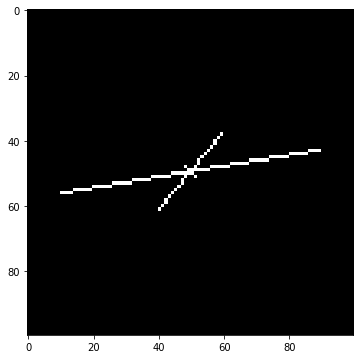

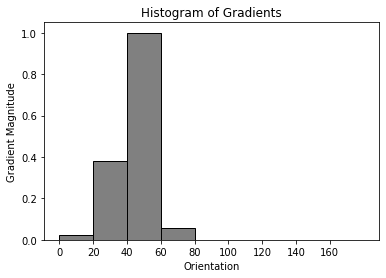

In [75]:
def afficher_une_cellule(hist, x, y):
    
    cell = hist[x,y]
    height = 100
    width = 100
    hog_image = np.zeros((height, width))
    
    centre_cell = 8 / 2
    max_mag = np.array(cell).max()
    
    grad = cell
    grad /= max_mag
    angle = 0
    angle_gap = 360 / 9 # divisé par le nombre de bins
                
    for magnitude in grad:
        angle_radian = math.radians(angle)
        x1 = int(height//2 + magnitude * centre_cell * math.cos(angle_radian) * 10)
        y1 = int(width//2 - magnitude * centre_cell * math.sin(angle_radian) * 10)
        x2 = int(height//2 - magnitude * centre_cell * math.cos(angle_radian) * 10)
        y2 = int(width//2 + magnitude * centre_cell * math.sin(angle_radian) * 10)
        cv2.line(hog_image, (y1, x1), (y2, x2), (255,255,255))
        angle += angle_gap
    
    plt.figure(figsize = (6,6))
    plt.imshow(hog_image, 'gray')
    plt.show()

afficher_une_cellule(histograms_fleche, 10, 6)
afficher_hist(histograms_fleche[10,6,:], hist_bins)

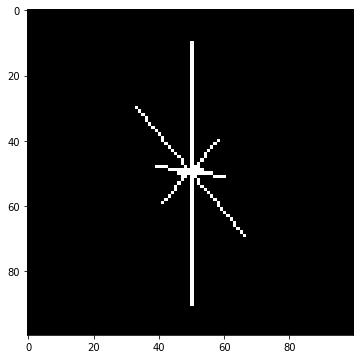

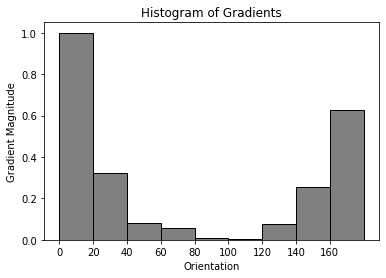

In [86]:
afficher_une_cellule(histograms_cam, 7, 7)
afficher_hist(histograms_cam[7,7,:], hist_bins)

## 5 : Normalisation des gradients

Bien que nous disposions déjà des caractéristiques HOG créées pour les cellules 8×8 de l'image, les gradients de l'image sont sensibles à l'éclairage général. Cela signifie que pour une image particulière, une partie de l'image serait très lumineuse par rapport aux autres parties. On peut réduire cela en créant des blocs de 16x16 pixels, regroupant 4 cellules (2x2). A la fin nous aurons pour chaque bloc une matrice 36x1.

Pour ce faire utilisons le vecteur V :

$$V=[a_1,a_2,...,a_{36}]$$

On calcule k qui va servir à normaliser en divisant V par k :

$$k=\sqrt{a_1^2 + a_2^2 + ... + a_{36}^2}$$

In [15]:
def final_vector(histograms, nb_cells_y, nb_cells_x):
    
    
    e = 1e-3
    # On veut des blocs de 4 fenêtres = 2*2
    bx = 2
    by = 2
    
    n_blocksx = (nb_cells_x - bx) + 1 # nombre de blocs sur x
    n_blocksy = (nb_cells_y - by) + 1 # nombre de blocs sur y
    
    all_vector = np.zeros((n_blocksy, n_blocksx, 36)) # vecteur V pour chaque bloc
    vector = np.zeros(36)
    
    for x in range(n_blocksx):
        for y in range(n_blocksy):
            
            all_vector[y,x,0:9] = histograms[y,x,:]
            all_vector[y,x,9:18] = histograms[y,x+1,:]
            all_vector[y,x,18:27] = histograms[y+1,x,:]
            all_vector[y,x,27:36] = histograms[y+1,x+1,:]
            
            somme_carre = 0
            for i in range(36):
                somme_carre += all_vector[y,x,i]**2
                
            k = np.sqrt(somme_carre) + e
            
            all_vector[y,x,:] = all_vector[y,x,:]/k
    
    return all_vector

all_vector_cam = final_vector(histograms_cam, 16, 8)
all_vector_fleche = final_vector(histograms_fleche, 16, 8)
all_vector_cam.shape

(15, 7, 36)

On a maintenant 15x7 = 105 blocs normalisés !

Chacun de ses blocs contient 9x4 = 36 caractéristiques d'orientation et de magnitude. (9 = bins (degrés) et 4 = nombres de fenêtre par bloc)

Au total on a 105x36 = 3780 caractéristiques ! 

## 6. Afficher HOG

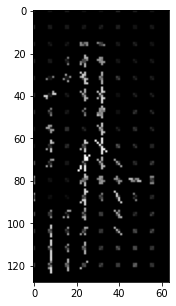

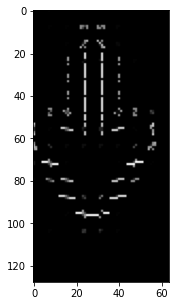

In [16]:
def afficher_image(hist):
    
    height = 128
    width = 64
    hog_image = np.zeros((height, width))
    
    centre_cell = 8 / 2
    max_mag = np.array(hist).max()
    
    for x in range(hist.shape[0]):
            for y in range(hist.shape[1]):
                
                grad = hist[x][y]
                grad /= max_mag
                angle = 0
                angle_gap = 360 / 9 # divisé par le nombre de bins
                
                for magnitude in grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * 8 + magnitude * centre_cell * math.cos(angle_radian))
                    y1 = int(y * 8 - magnitude * centre_cell * math.sin(angle_radian))
                    x2 = int(x * 8 - magnitude * centre_cell * math.cos(angle_radian))
                    y2 = int(y * 8 + magnitude * centre_cell * math.sin(angle_radian))
                    cv2.line(hog_image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
    
    plt.figure(figsize = (10,5))
    plt.imshow(hog_image, 'gray')
    plt.show()
    
afficher_image(histograms_cam)
afficher_image(histograms_fleche)

## Comparaison : utilisation de la fonction d'OpenCV

In [69]:
from skimage.feature import hog

fd, hog_image_cam = hog(image_cam, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
fd, hog_image_fleche = hog(image_fleche, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

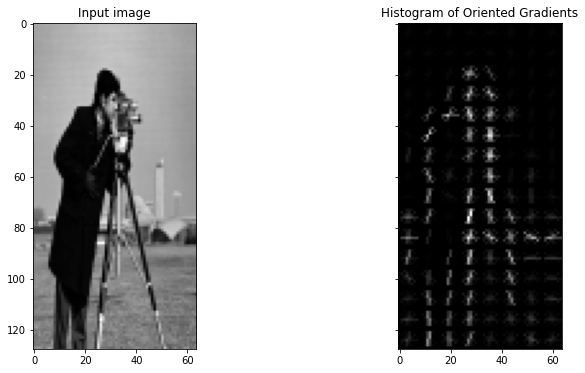

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True) 

ax1.imshow(image_cam, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

ax2.imshow(hog_image_cam, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

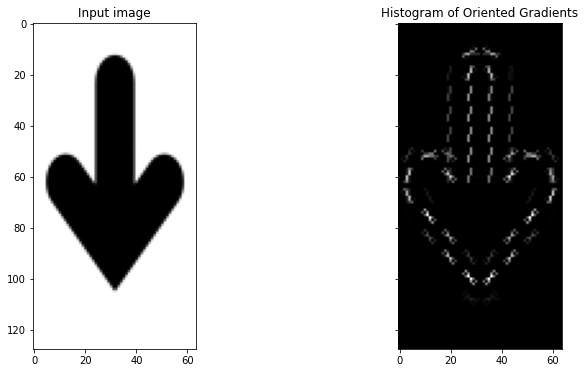

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True) 

ax1.imshow(image_fleche, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

ax2.imshow(hog_image_fleche, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()